In [61]:
%config InlineBackend.figure_format = "retina" # High-res graphs (rendered irrelevant by svg option below)
%config InlineBackend.print_figure_kwargs = {"bbox_inches": "tight"} # No extra white space
%config InlineBackend.figure_format = "svg" # 'png' is default

from IPython.core.debugger import set_trace
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import scipy as sp

### load the data

In [2]:
# get the list of subjects
subList = []
dataFolder = '../Data_equalWeights/'
allFileNames = os.listdir(dataFolder)
for fileName in allFileNames:
    if fileName.startswith('wizard_gems_data'):
        subList.append(fileName[17:17+15])

In [3]:
data = pd.DataFrame()
for iSub, sub in enumerate(subList):
    dataSub = pd.read_csv(dataFolder+'preprocessed_data_'+sub+'_2019-08-10.csv')
    data = data.append(dataSub)

### estimate betas

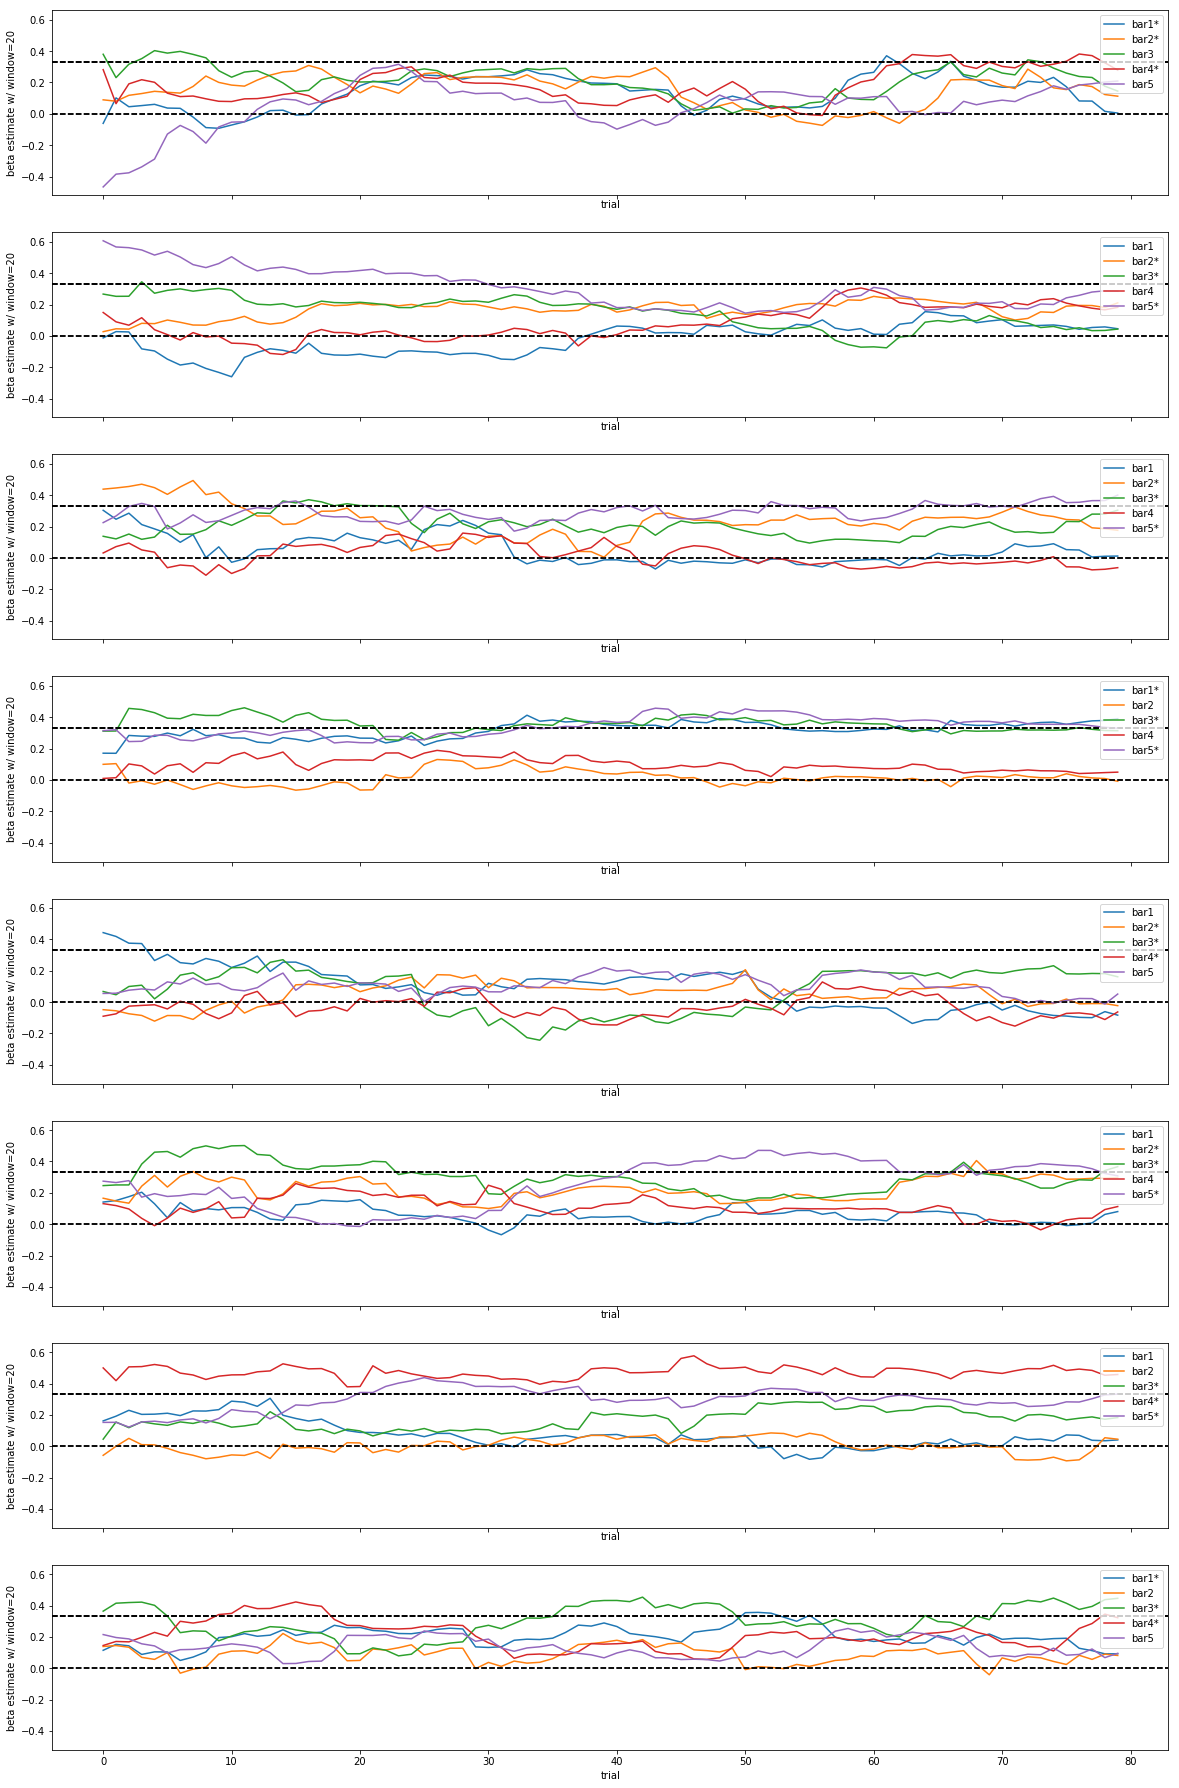

In [4]:
import statsmodels.api as sm

window = 20

fig, axes = plt.subplots(len(subList),1,figsize=(20,4*len(subList)),sharex=True,sharey=True)
cols = ['bars'+str(i+1) for i in range(5)]
coef = np.empty((len(subList), data['NTrials'].max()-window, 6))
coef[:] = np.nan
for iSub, sub in enumerate(subList):
    dataSub = data[(data['sub']==iSub+1)].copy().reset_index(drop=True)
    beta = [dataSub.loc[0,'weights'+str(iBar+1)] for iBar in range(5)]
    for i in np.arange(dataSub.loc[0,'NTrials']-window):
        dataWindow = dataSub.iloc[i:i+window]
        X = dataWindow[cols].values
        y = dataWindow['response'].values
        X = sm.add_constant(X)
        mod = sm.OLS(y, X)
        res = mod.fit()
        coef[iSub, i, -1] = res.params[0]/100
        coef[iSub, i, 0:-1] = res.params[1:]
    for iBar in range(5):
        axes[iSub].plot(coef[iSub, :, iBar], color='C'+str(iBar), label='bar'+str(iBar+1)+('*' if beta[iBar]>0 else ''))
        axes[iSub].axhline(y=beta[iBar], linestyle='--', color='k')
#     axes[iSub].set_ylim([0,1])
    axes[iSub].legend(loc=1)
    axes[iSub].set(xlabel='trial',ylabel='beta estimate w/ window='+str(window))

### absolute error

In [5]:
data['absError'] = np.abs(data['correct_response'] - data['response'])

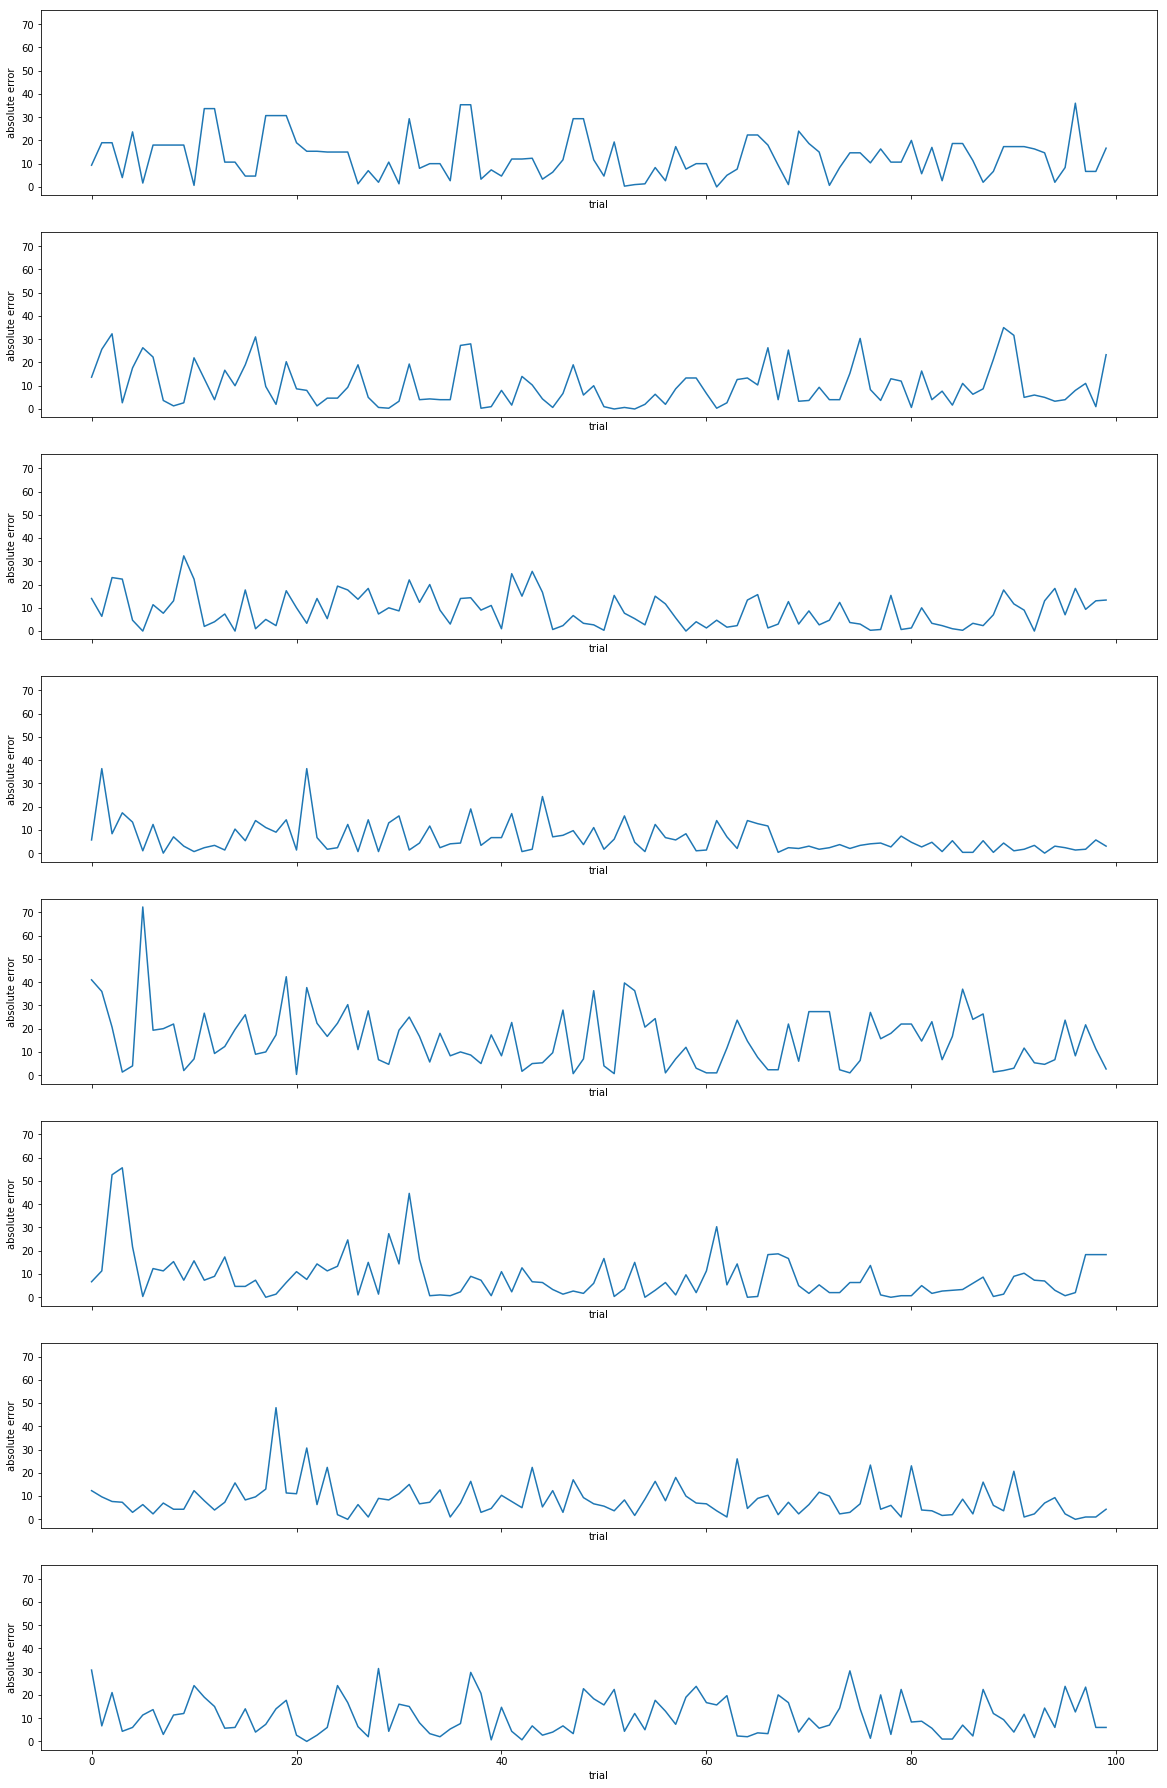

In [6]:
fig, axes = plt.subplots(len(subList),1,figsize=(20,4*len(subList)),sharex=True,sharey=True)
for iSub, sub in enumerate(subList):
    axes[iSub].plot(data.loc[data['sub']==iSub+1, 'absError'])
    axes[iSub].set(xlabel='trial',ylabel='absolute error')

### Split people into learners and non-learners
We'll just do a median split on sum squared error for the subjects in the last 50 trials.

In [127]:
def extract_subject_coefficients(coefficients, subject):
    """Extracts the coefficients for a given subject, 
    stripping out nan values since not all subjects have 
    the same number of trials.
    coefficients: 3D numpy array -> (subject, trial, param)
    subject: int -> subject number
    """
    x = np.copy(coefficients) # just to be sure we don't end up messing up the original reference
    x = x[subject, : , :]
    x = x[~np.isnan(x).any(axis=1)]
    return x

def get_sum_square_errors(a, b):
    return np.sum((a - b)**2)

def get_beta_weights(data):
    return np.array([data.loc[0,'weights'+str(bar + 1)] for bar in range(5)])

def get_sorted_beta_weights(beta_weights):
    beta_weight_sort_order = np.argsort(beta_weights)
    return beta_weight_sort_order, beta_weights[beta_weight_sort_order]

def get_sorted_subject_coefficients(subject_coefficients, subject_data):
#     set_trace()
    beta_weights = get_beta_weights(subject_data)
    beta_weight_sort_order, sorted_beta_weights = get_sorted_beta_weights(beta_weights)
    return subject_coefficients[:, beta_weight_sort_order]

def get_subject_data(subject, data):
    return data[(data['sub']==subject + 1)].copy().reset_index(drop=True)

# test_window = 50 # last trials on which to judge degree of learning
num_subjects = coef.shape[0]
sum_square_errors = np.zeros((num_subjects, 5)) # the errors in learning for each beta weight
avg_sum_square_errors = np.zeros((num_subjects, 5))
all_betas = np.zeros((num_subjects, 5))
for subject in range(num_subjects): 
    subject_data = get_subject_data(subject, data)
    subject_coefficients = extract_subject_coefficients(coef, subject)
    beta_weights = get_beta_weights(subject_data)
    all_betas[subject, :] = beta_weights
    num_trials = subject_coefficients.shape[0]
    all_trials_coefficients = subject_coefficients[:, :-1] # remove constant
    for bar in range(len(beta_weights)):
        sum_square_errors[subject, bar] = get_sum_square_errors(all_trials_coefficients[:, bar], beta_weights[bar])
        avg_sum_square_errors[subject, bar] = sum_square_errors[subject, bar] / num_trials

avg_collapsed_sum_square_errors = np.mean(avg_sum_square_errors, axis=1)
learner_threshold = np.median(avg_collapsed_sum_square_errors)
learner_indices = np.where(avg_collapsed_sum_square_errors< learner_threshold)[0]
print(learner_indices)

[2 3 5 6]


subject: 3, error_sort_order: [1 0 2]
subject: 2, error_sort_order: [2 0 1]
subject: 6, error_sort_order: [2 1 0]
subject: 5, error_sort_order: [1 0 2]
subject: 7, error_sort_order: [1 0 2]
subject: 1, error_sort_order: [2 0 1]
subject: 0, error_sort_order: [2 1 0]
subject: 4, error_sort_order: [0 1 2]


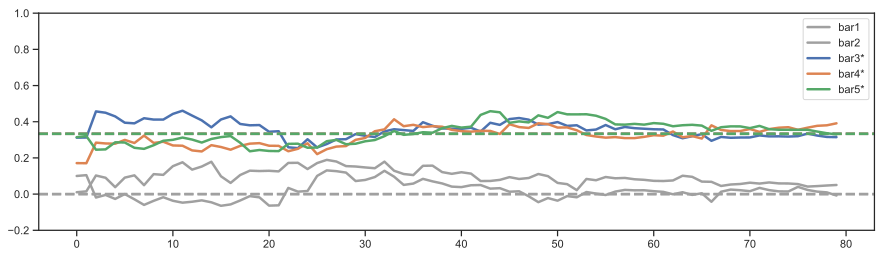

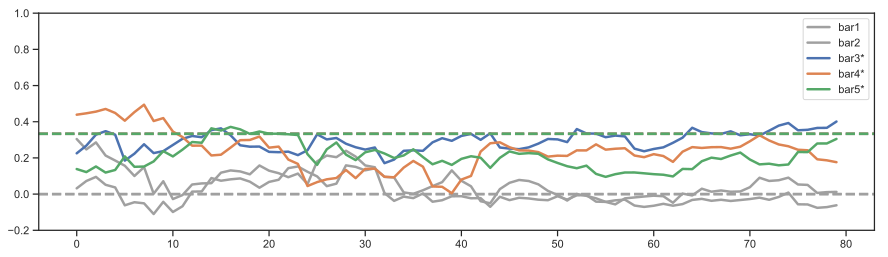

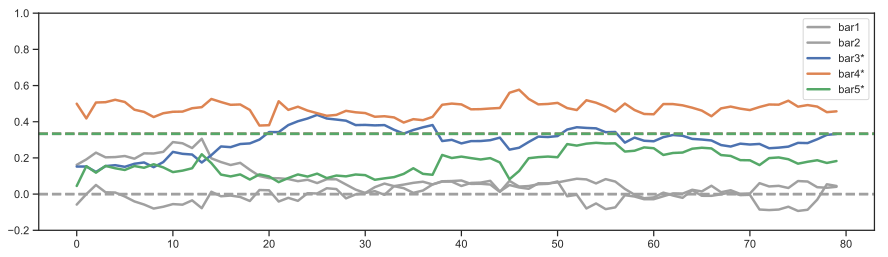

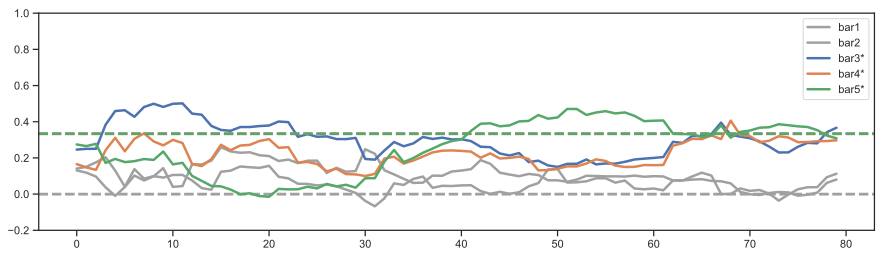

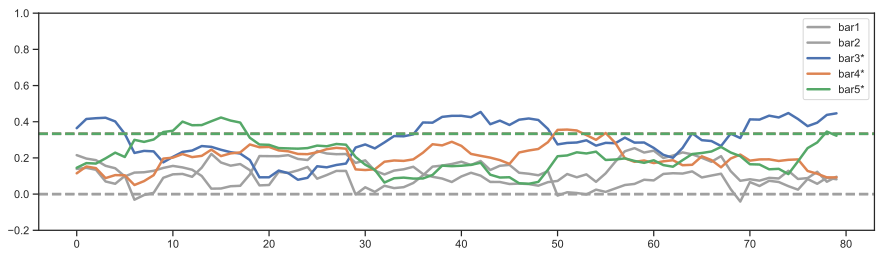

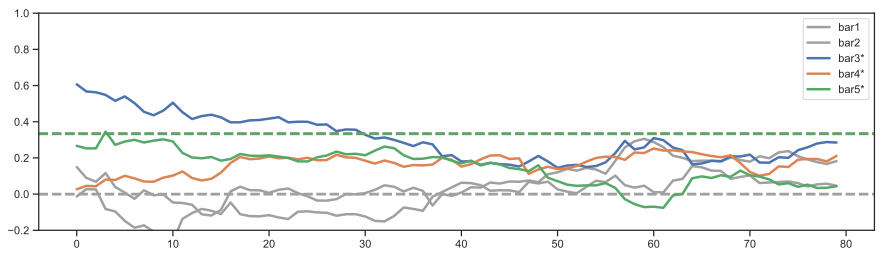

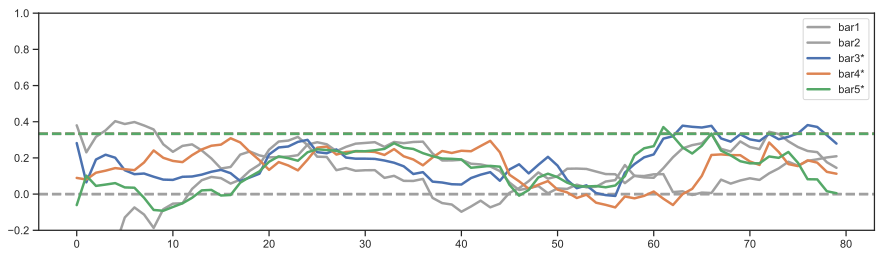

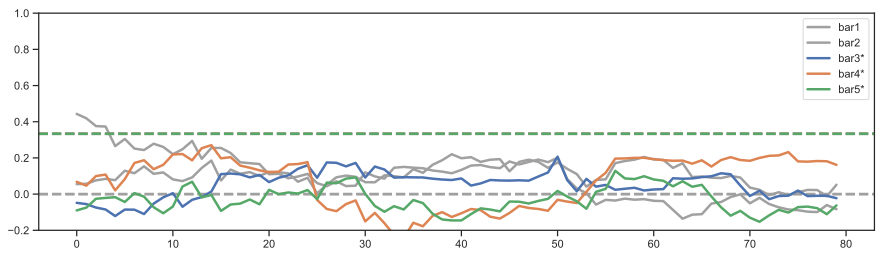

In [184]:
def plot_subject_coefficients(coefficients, beta_weights):
    fig, axes = plt.subplots(1, 1, figsize=(15, 4))
    cols = ["bars" + str(i + 1) for i in range(5)]
    for bar in range(5):
        axes.plot(
            coefficients[:, bar],
            color="C" + str(bar) if beta_weights[bar] > 0 else "#A0A0A0",
            label="bar" + str(bar + 1) + ("*" if beta_weights[bar] > 0 else ""),
        )
        axes.axhline(y=beta_weights[bar], linestyle="--", color="C" + str(bar))
    axes.set_ylim([-0.2, 1])
    plt.legend()


# Plot subject coefficients in ascending order of error
subject_sort_order = np.argsort(avg_collapsed_sum_square_errors)
all_sorted_subject_coefficients = {}
for subject in subject_sort_order:
    subject_data = get_subject_data(subject, data)
    subject_coefficients = extract_subject_coefficients(coef, subject)
    beta_weights = all_betas[subject, :]
    beta_weight_sort_order, sorted_beta_weights = get_sorted_beta_weights(beta_weights)
    sorted_subject_coefficients = get_sorted_subject_coefficients(subject_coefficients, subject_data)
    # Resort based on the error levels
    sorted_avg_sum_square_errors = avg_sum_square_errors[:, beta_weight_sort_order]
    non_zero_avg_sum_square_errors = sorted_avg_sum_square_errors[subject, 2:]
    error_sort_order = np.argsort(non_zero_avg_sum_square_errors)
    zero_bar_coefficients = sorted_subject_coefficients[:, :2]
    non_zero_bar_coefficients = sorted_subject_coefficients[:, 2:]
    non_zero_bar_coefficients = non_zero_bar_coefficients[:, error_sort_order]
    sorted_subject_coefficients = np.concatenate((zero_bar_coefficients, non_zero_bar_coefficients), axis=1)
#     set_trace()
    print(f"subject: {subject}, error_sort_order: {error_sort_order}")
    all_sorted_subject_coefficients[subject] = sorted_subject_coefficients
    plot_subject_coefficients(sorted_subject_coefficients, sorted_beta_weights)

In [140]:
# np.sum((non_zero_bar_coefficients[:, 0] - 0.3333)**2)

6.7833898937949915

# Plot the average learner and non-learner curves up to the point where they all have trial data

In [157]:
def get_min_trials(coefficients):
    num_subjects = coefficients.shape[0]
    min_trials = np.inf
    for subject in range(num_subjects):
        subject_coefficients = extract_subject_coefficients(coef, subject)
        num_trials = subject_coefficients.shape[0]
        if min_trials > num_trials:
            min_trials = num_trials
    return min_trials


def get_dataframe_of_coefficients(orig_data, all_sorted_subject_coefficients, num_trials, learner_indices):
    weight_dict = {key: f"weight_{key}" for key in range(6)}
    columns = [
        "subject_number",
        "learner",
        "trial",
        "weight_num",
        "weight",
        "true_weight",
    ]
    index = []
    data = pd.DataFrame(index=index, columns=columns)
    data_template = data.copy()
    num_subjects = len(all_sorted_subject_coefficients.keys())
    frames = []
    for subject in range(num_subjects):
        print(subject)
        subject_data = data_template.copy()
        orig_subject_data = get_subject_data(subject, orig_data)
        beta_weights = get_beta_weights(orig_subject_data)
        sorted_beta_weights = np.sort(beta_weights)
        sorted_subject_coefficients = all_sorted_subject_coefficients[subject]
        if subject in learner_indices:
            learner = True
        else:
            learner = False
        for trial, row in enumerate(sorted_subject_coefficients[:num_trials, :]):
            for weight_num, weight in enumerate(row):
                weight_name = weight_dict[weight_num]
                true_weight = sorted_beta_weights[weight_num] if weight_num < 5 else 0
                new_row = [subject, learner, trial, weight_name, weight, true_weight]
                subject_data = subject_data.append(
                    pd.DataFrame([new_row], index=["e"], columns=subject_data.columns)
                )

        frames.append(subject_data)
    data = pd.concat(frames)
    return data


min_trials = get_min_trials(coef)
data_for_plotting = get_dataframe_of_coefficients(
    data, all_sorted_subject_coefficients, min_trials, learner_indices
)
data_for_plotting.reset_index(drop=True, inplace=True)
data_for_plotting.shape

0
1
2
3
4
5
6
7


(3200, 6)

In [158]:
data_for_plotting.head()

,subject_number,learner,trial,weight_num,weight,true_weight
0,0,False,0,weight_0,0.380003,0.000000
1,0,False,0,weight_1,-0.466048,0.000000
2,0,False,0,weight_2,0.281849,0.333333
3,0,False,0,weight_3,0.089460,0.333333
4,0,False,0,weight_4,-0.060674,0.333333


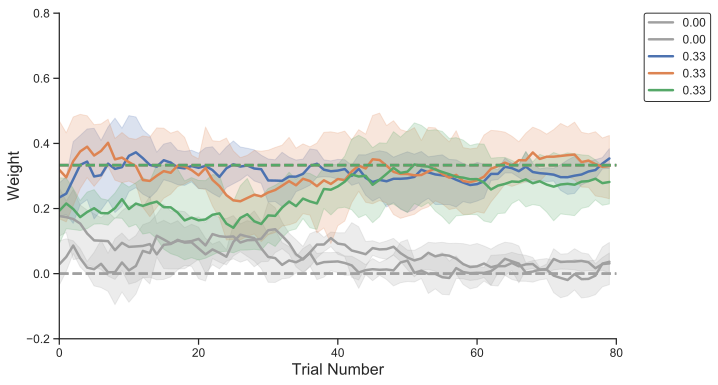

In [191]:
def plot_average_data(data, beta_weights, filename=None):
    """Plots the data for the estimated weights 
    across all trials, along with dashed lines for the 
    constants defined in beta_weights."""
    
    sns.set(style="ticks", rc={"lines.linewidth": 2.5})
    
    # Custom color palette
    custom_palette = ["#A0A0A0", "#A0A0A0", *sns.color_palette()]
    sns.set_palette(custom_palette)
    plt.figure(figsize=(10, 6))
    
    ax = sns.lineplot(x="trial", y="weight", hue="weight_num", data=data)
    # Draw constant horizontal lines
    for i, beta in enumerate(beta_weights):
        ax.axhline(y=beta, linestyle="--", color="C" + str(i))

    # Legend
    legend_labels = ["{:.2f}".format(beta) for beta in beta_weights]

    # move legend outside of plot
    leg = plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.0,
        fontsize=12,
        labels=legend_labels,
    )

    # change legend frame color
    leg.get_frame().set_edgecolor("#000000")

    # Change font sizes and labels
    ax.set_ylabel("Weight", fontsize=16)
    ax.set_xlabel("Trial Number", fontsize=16)

    # Set axis limits
    ax.set_ylim([-0.2, 0.8])
    ax.set_xlim([0, data["trial"].max()])

    # Change ticks
    x_tick_step = 20
    plt.xticks(np.arange(0, data["trial"].max() + x_tick_step, x_tick_step))
    ax.tick_params(labelsize=12)

    # Remove top and right borders
    sns.despine()

    # Save figure
    if filename is not None:
        plt.savefig(filename)


sorted_beta_weights = np.sort(beta_weights)
learner_data = data_for_plotting[data_for_plotting["learner"] == 1]
plot_average_data(learner_data, sorted_beta_weights, filename="new_task_learner.svg") # filename="learner.svg"

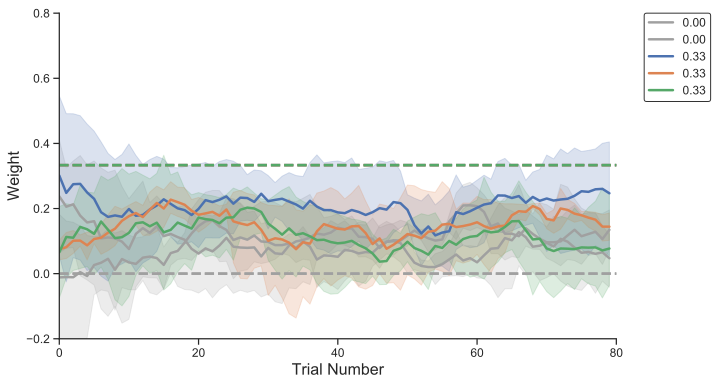

In [192]:
non_learner_data = data_for_plotting[data_for_plotting["learner"] == 0]
plot_average_data(non_learner_data, sorted_beta_weights, filename="new_task_non-learner.svg") #  filename="non-learner.svg"